In [1]:
from deepee import (PrivacyWrapper, PrivacyWatchdog, UniformDataLoader,
                     ModelSurgeon, SurgicalProcedures)
import torch
import numpy as np
from torch import nn
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
import cv2
from torchvision.transforms import functional as F

class args:
    batch_size = 200
    test_batch_size = 200
    log_interval = 1000
    num_epochs = 5
    device = "cuda" if torch.cuda.is_available() else "cpu"
device = args.device

In [2]:
train_loader = UniformDataLoader(
    
    datasets.MNIST(
        "./data",
        train=True,
        download=True,
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        ),
    ),
    batch_size=args.batch_size,
)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "./data",
        train=False,
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        ),
    ),
    batch_size=args.test_batch_size,
    shuffle=True,
) 

/Users/helena/.virtualenvs/thesis/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.bn1 = nn.BatchNorm1d(256, track_running_stats=False)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = torch.sigmoid(self.fc1(x))
        x = self.bn1(x)
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.308876


INFO:root:Privacy spent at 100 steps: 0.18
INFO:root:Privacy spent at 200 steps: 0.27
INFO:root:Privacy spent at 300 steps: 0.34



Test set: Average loss: 0.6094, Accuracy: 8416/10000 (84%)
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.647135


INFO:root:Privacy spent at 400 steps: 0.39
INFO:root:Privacy spent at 500 steps: 0.44
INFO:root:Privacy spent at 600 steps: 0.49



Test set: Average loss: 0.3920, Accuracy: 8994/10000 (90%)
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.444193


INFO:root:Privacy spent at 700 steps: 0.53
INFO:root:Privacy spent at 800 steps: 0.57
INFO:root:Privacy spent at 900 steps: 0.61



Test set: Average loss: 0.3545, Accuracy: 9137/10000 (91%)
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.321352


INFO:root:Privacy spent at 1000 steps: 0.65
INFO:root:Privacy spent at 1100 steps: 0.68
INFO:root:Privacy spent at 1200 steps: 0.72



Test set: Average loss: 0.3021, Accuracy: 9228/10000 (92%)
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.243743


INFO:root:Privacy spent at 1300 steps: 0.75
INFO:root:Privacy spent at 1400 steps: 0.78
INFO:root:Privacy spent at 1500 steps: 0.81



Test set: Average loss: 0.2871, Accuracy: 9264/10000 (93%)


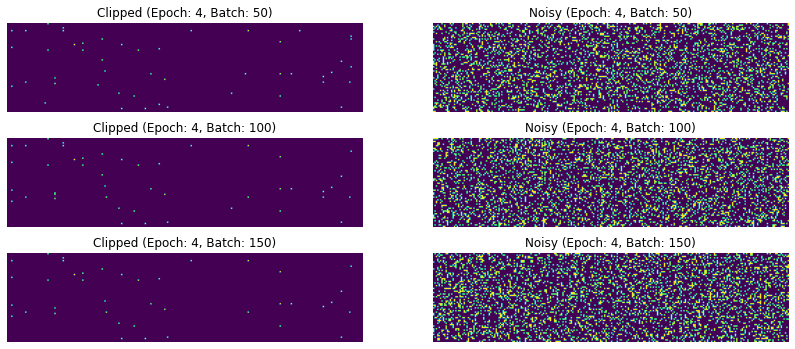

In [12]:
watchdog = PrivacyWatchdog(
    train_loader,
    target_epsilon=1.0,
    abort=False,
    target_delta=1e-5,
    fallback_to_rdp=False,
)
model = PrivacyWrapper(SimpleNet(), args.batch_size, 1.0, 1.0, watchdog=watchdog).to(
    args.device
)
optimizer = torch.optim.SGD(model.wrapped_model.parameters(), lr=0.1)

surgeon = ModelSurgeon(SurgicalProcedures.BN_to_GN)
model = surgeon.operate(model)

rows = 3
columns = 2
i = 1
fig = plt.figure(figsize=(columns*7, rows*2))

# Train
for epoch in range(args.num_epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.CrossEntropyLoss()(output, target)
        loss.backward()
        
        if epoch == 4 and (batch_idx == 50 or batch_idx == 100 or batch_idx == 150):
            model.clip_and_accumulate()
            fig.add_subplot(rows, columns, i)
            plt.imshow(F.to_pil_image(model.wrapped_model.fc2.weight.grad))
            plt.axis('off')
            plt.title("Clipped (Epoch: " + str(epoch) + ", Batch: " + str(batch_idx) + ")")
        
            model.noise_gradient()
            fig.add_subplot(rows, columns, i+1)
            plt.imshow(F.to_pil_image(model.wrapped_model.fc2.weight.grad))
            plt.axis('off')
            plt.title("Noisy (Epoch: " + str(epoch) + ", Batch: " + str(batch_idx) + ")")
            
            i = i+2
        else:
            model.clip_and_accumulate()
            model.noise_gradient()

        optimizer.step()
        model.prepare_next_batch()
        if batch_idx % args.log_interval == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )

    # Test
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += torch.nn.CrossEntropyLoss(reduction="sum")(
                output, target
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.387445


INFO:root:Privacy spent at 100 steps: 0.18
INFO:root:Privacy spent at 200 steps: 0.27
INFO:root:Privacy spent at 300 steps: 0.34



Test set: Average loss: 1.6210, Accuracy: 6365/10000 (64%)


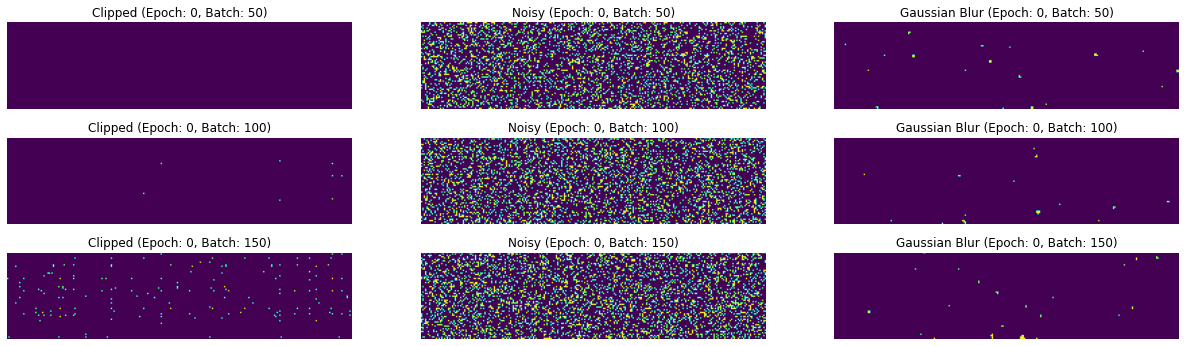

In [10]:
watchdog = PrivacyWatchdog(
    train_loader,
    target_epsilon=1.0,
    abort=False,
    target_delta=1e-5,
    fallback_to_rdp=False,
)
model = PrivacyWrapper(SimpleNet(), args.batch_size, 1.0, 1.0, watchdog=watchdog).to(
    args.device
)
optimizer = torch.optim.SGD(model.wrapped_model.parameters(), lr=0.1)

surgeon = ModelSurgeon(SurgicalProcedures.BN_to_GN)
model = surgeon.operate(model)

rows = 3
columns = 3
i = 1
fig = plt.figure(figsize=(columns*7, rows*2))

# Train
for epoch in range(1):#(args.num_epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.CrossEntropyLoss()(output, target)
        loss.backward()
        
        if epoch == 0 and (batch_idx == 50 or batch_idx == 100 or batch_idx == 150):
            model.clip_and_accumulate()
            fig.add_subplot(rows, columns, i)
            plt.imshow(F.to_pil_image(model.wrapped_model.fc2.weight.grad))
            plt.axis('off')
            plt.title("Clipped (Epoch: " + str(epoch) + ", Batch: " + str(batch_idx) + ")")
        
            model.noise_gradient()
            fig.add_subplot(rows, columns, i+1)
            plt.imshow(F.to_pil_image(model.wrapped_model.fc2.weight.grad))
            plt.axis('off')
            plt.title("Noisy (Epoch: " + str(epoch) + ", Batch: " + str(batch_idx) + ")")
            
            model.wrapped_model.fc1.weight.grad = torch.tensor(
                cv2.GaussianBlur(np.array(model.wrapped_model.fc1.weight.grad), (5,5), 0)
            )
            model.wrapped_model.fc2.weight.grad = torch.tensor(
                cv2.GaussianBlur(np.array(model.wrapped_model.fc2.weight.grad), (5,5), 0)
            )
            model.wrapped_model.fc3.weight.grad = torch.tensor(
                cv2.GaussianBlur(np.array(model.wrapped_model.fc3.weight.grad), (5,5), 0)
            )
            fig.add_subplot(rows, columns, i+2)
            plt.imshow(F.to_pil_image(model.wrapped_model.fc2.weight.grad))
            plt.axis('off')
            plt.title("Gaussian Blur (Epoch: " + str(epoch) + ", Batch: " + str(batch_idx) + ")")
            
            i = i+3
        else:
            model.clip_and_accumulate()
            model.noise_gradient()
            model.wrapped_model.fc1.weight.grad = torch.tensor(
                cv2.GaussianBlur(np.array(model.wrapped_model.fc1.weight.grad), (5,5), 0)
            )
            model.wrapped_model.fc2.weight.grad = torch.tensor(
                cv2.GaussianBlur(np.array(model.wrapped_model.fc2.weight.grad), (5,5), 0)
            )
            model.wrapped_model.fc3.weight.grad = torch.tensor(
                cv2.GaussianBlur(np.array(model.wrapped_model.fc3.weight.grad), (5,5), 0)
            )

        optimizer.step()
        model.prepare_next_batch()
        if batch_idx % args.log_interval == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )

    # Test
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += torch.nn.CrossEntropyLoss(reduction="sum")(
                output, target
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.305416

Test set: Average loss: 0.3648, Accuracy: 9092/10000 (91%)
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.354861

Test set: Average loss: 0.2862, Accuracy: 9221/10000 (92%)
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.278037

Test set: Average loss: 0.2443, Accuracy: 9309/10000 (93%)
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.283243

Test set: Average loss: 0.2182, Accuracy: 9388/10000 (94%)
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.190580

Test set: Average loss: 0.1888, Accuracy: 9464/10000 (95%)


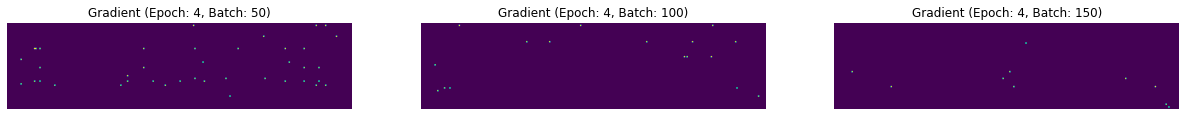

In [11]:
model = SimpleNet().to(args.device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

rows = 50
columns = 3
i = 1
fig = plt.figure(figsize=(columns*7, rows*2))

# Train
for epoch in range(args.num_epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.CrossEntropyLoss()(output, target)
        loss.backward()
        if epoch == 4 and (batch_idx == 50 or batch_idx == 100 or batch_idx == 150):
            fig.add_subplot(rows, columns, i)
            plt.imshow(F.to_pil_image(model.fc2.weight.grad))
            plt.axis('off')
            plt.title("Gradient (Epoch: " + str(epoch) + ", Batch: " + str(batch_idx) + ")")
            i = i+1
            
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )

    # Test
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += torch.nn.CrossEntropyLoss(reduction="sum")(
                output, target
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )